## Calculate the Windstress Curl using CookBook functionality

In [45]:
# Load modules
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap # plot on map projections
import seaborn as sns

from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
from mpl_toolkits.basemap import Basemap # plot on map projections
import xarray as xr


In [2]:
from joblib import Memory

memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

In [3]:
cc.start_cluster(diagnostics_port=8787)

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 8787:127.0.0.1:8787 vdi-n26.nci.org.au -l pas561


Client Scheduler: tcp://127.0.0.1:41388 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [4]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)
#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.10.0


In [27]:
#read in the grid dxt and dyt and coriolis from an unmasked ocean_grid.nc file
hgrid_file ='/g/data1/v45/pas561/mom/archive/VertOverturn/mom01_unmasked_ocean_grid.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print(geolon_t.shape)


(2700, 3600)
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --]


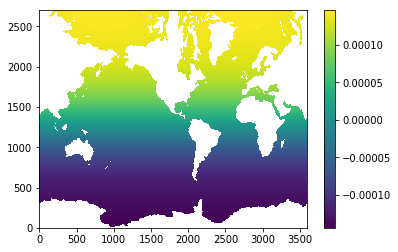

In [29]:
plt.pcolormesh(fcor)
plt.colorbar()

In [5]:
cc.build_index()


Found 3720 new variables
Saving results in database...
Indexing complete.


True

In [6]:
configuration = 'mom01v5'
expts = cc.get_experiments(configuration)
display(expts)


['GFDL50',
 'KDS75',
 'KDS75_PI',
 'KDS75_UP',
 'KDS75_WOA13',
 'KDS75_newbathy_CORE',
 'KDS75_newbathy_JRA',
 'KDS75_newbathy_JRA_runoff',
 'KDS75_salt10days',
 'KDS75_saltfluxes',
 'KDS75_wind',
 'kds75_cp',
 'kds75_wp2']

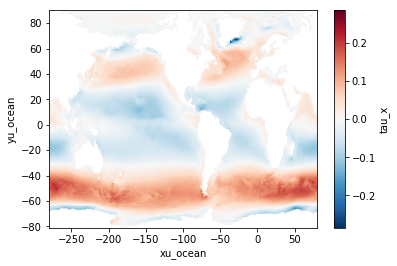

In [32]:
expt='kds75_cp'
tau_x= cc.get_nc_variable(expt,
                    'ocean.nc',
                    'tau_x',
                    time_units='days since 1860-01-01',
                    use_bag=True,
                    )
mean_tau_x = tau_x.sel(time='1975').mean('time').load()
mean_tau_x.plot.pcolormesh()

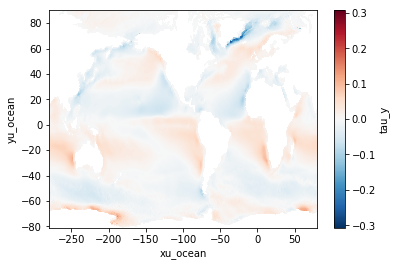

In [33]:
expt='kds75_cp'
tau_y= cc.get_nc_variable(expt,
                    'ocean.nc',
                    'tau_y',
                    time_units='days since 1860-01-01',
                    use_bag=True,
                    )
mean_tau_y = tau_y.sel(time='1975').mean('time').load()
mean_tau_y.plot.pcolormesh()

In [34]:
print(mean_tau_x.shape)
print(mean_tau_y.shape)
print(fcor.shape)

(2700, 3600)
(2700, 3600)
(2700, 3600)


In [35]:
Txf=mean_tau_x/fcor

In [38]:
print(dxt.shape)
print(dxt.shape)

(2700, 3600)


In [51]:
#plot wind stress curl ... Ekman pumping anomalies.
#(d(Tau_y/f) /dx - d(Tau_x/f) / dy) /rho_0

Txf=mean_tau_x/fcor
Tyf=mean_tau_y/fcor
print(Txf.shape)
print(dxt.shape)

#using python 2.7 you could take a 2D gradient. With python3 this functionality was lost 
#see https://github.com/numpy/numpy/issues/9401
#So the code below now crashes using python3, which sucks
#dTyfdx=np.gradient(Tyf,dxt,axis=1)
#dTxfdy=np.gradient(Txf,dyt,axis=0)

#this works though ...
dTyfdx=np.gradient(Tyf,1,axis=1)/dxt
print(dTyfdx.shape)

dTxfdy=np.gradient(Txf,1,axis=0)/dyt
print(dTxfdy.shape)

rho0=1035.0
we=(dTyfdx-dTxfdy)/rho0

#convert from m/s to m/day
s_day=60*60*24
we=we*s_day




(2700, 3600)
(2700, 3600)
(2700, 3600)
(2700, 3600)


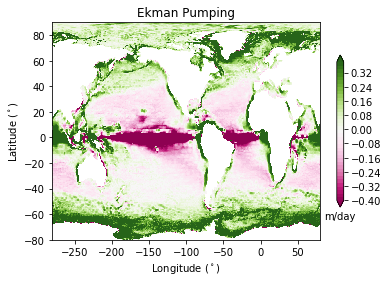

In [50]:
clev = np.arange(-.4,.4,.02)

plt.contourf(geolon_t,geolat_t,we,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m/day')
#clev = np.arange(-2,1,0.2)
#plt.contour(geolon_t,geolat_t,ssh[0],levels=clev,colors='k',linewidths=0.25)
#plt.contour(geolon_t,geolat_t,ssh[0],levels=[0.0,],colors='k',linewidths=0.5)

plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Longitude ($^\circ$)')
plt.ylim([-80,90])
plt.xlim([-280,80])
plt.title('Ekman Pumping')

#plt.savefig('/Users/johnspence/Documents/ccrcproc/VertOverturn/wt_2500.pdf')

plt.show()
